# long-short-portfolio

On the first trading day of every month, rebalance portfolio to given percentages.  One of the positions is a short position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
portfolio_option = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}

directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}

Some global data

In [4]:
symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
}
options

{'use_adj': True, 'use_cache': True}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts)

In [7]:
pf.TradeLog.cash = capital

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        #portfolio.print_holdings(date, row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)

        # Get closing prices for all symbols
        p = portfolio.get_prices(row, fields=['close'])
        prices = {symbol:p[symbol]['close'] for symbol in portfolio.symbols}
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(date, prices, weights, row, directions)

    # Record daily balance.
    portfolio.record_daily_balance(date, row)

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,50.48,19,entry,SHRT,TLT_SHRT
1,2004-12-01,1,85.40,58,entry,LONG,SPY
2,2004-12-01,2,45.38,22,entry,LONG,GLD
3,2004-12-01,3,50.48,59,entry,LONG,TLT
4,2005-01-03,4,43.02,1,entry,LONG,GLD
5,2005-01-03,5,52.02,1,exit,LONG,TLT
6,2005-02-01,6,53.67,1,exit,SHRT,TLT_SHRT
7,2005-02-01,7,53.67,2,exit,LONG,TLT
8,2005-03-01,8,52.95,1,entry,SHRT,TLT_SHRT
9,2005-03-01,9,52.95,1,entry,LONG,TLT


In [10]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
330,2015-11-02,107.01,2021-08-02,150.10,43.09,86.18,2,20146.72,LONG,TLT
331,2015-11-02,108.59,2021-11-15,174.16,65.57,65.57,1,20212.29,LONG,GLD
332,2015-12-01,102.28,2021-11-15,174.16,71.88,71.88,1,20284.17,LONG,GLD
333,2016-01-04,180.75,2021-11-15,467.43,286.68,286.68,1,20570.85,LONG,SPY
334,2016-02-01,174.12,2021-11-15,467.43,293.31,586.62,2,21157.48,LONG,SPY
...,...,...,...,...,...,...,...,...,...,...
425,2021-09-01,148.51,2021-11-15,145.48,3.03,3.03,1,28199.05,SHRT,TLT_SHRT
426,2021-09-01,148.51,2021-11-15,145.48,-3.03,-6.06,2,28192.99,LONG,TLT
427,2021-10-01,434.24,2021-11-15,467.43,33.19,33.19,1,28226.18,LONG,SPY
428,2021-11-01,167.52,2021-11-15,174.16,6.64,6.64,1,28232.82,LONG,GLD


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-11-09,41409.38,41409.38,41409.38,178,1661.41,1.00,-
2021-11-10,41134.02,41134.02,41134.02,178,1661.41,1.00,-
2021-11-11,41151.58,41151.58,41151.58,178,1661.41,1.00,-
2021-11-12,41277.10,41277.10,41277.10,178,1661.41,1.00,-
2021-11-15,38230.90,38230.90,38230.90,0,38230.90,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                    2004-11-18
end                                                      2021-11-15
beginning_balance                                             10000
ending_balance                                             38230.90
total_net_profit                                           28230.90
gross_profit                                               31249.73
gross_loss                                                 -3018.84
profit_factor                                                 10.35
return_on_initial_capital                                    282.31
annual_return_rate                                             8.21
trading_period                           16 years 11 months 28 days
pct_time_in_market                                            99.81
margin                                                            1
avg_leverage                                                   1.00
max_leverage                                    

,cumul_total,weight,pct_cumul_total,relative_performance
TLT_SHRT,"-$2,041.11",0.10,-0.07,-0.72
SPY,"$21,634.84",0.50,0.77,1.53
GLD,"$2,464.46",0.10,0.09,0.87
TLT,"$6,172.71",0.30,0.22,0.73
TOTAL,"$28,230.90",1.00,1.00,1.00


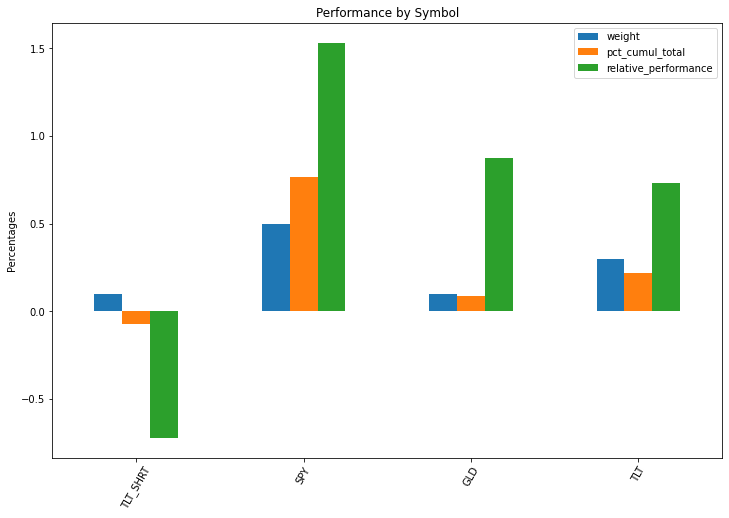

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

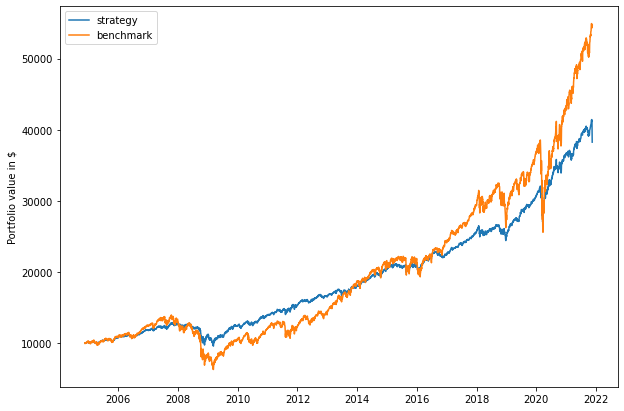

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [16]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$38,230.90","$54,738.43"
total_net_profit,"$28,230.90","$44,738.43"
gross_profit,"$31,249.73","$44,738.43"
gross_loss,"-$3,018.84",$0.00


,strategy,benchmark
annual_return_rate,8.21,10.52
max_closed_out_drawdown,-25.70,-54.99
annualized_return_over_max_drawdown,0.32,0.19
best_month,14.11,23.44
worst_month,-15.61,-30.95
sharpe_ratio,0.92,0.62
sortino_ratio,1.11,0.74
monthly_std,2.22,4.49
annual_std,7.75,16.34


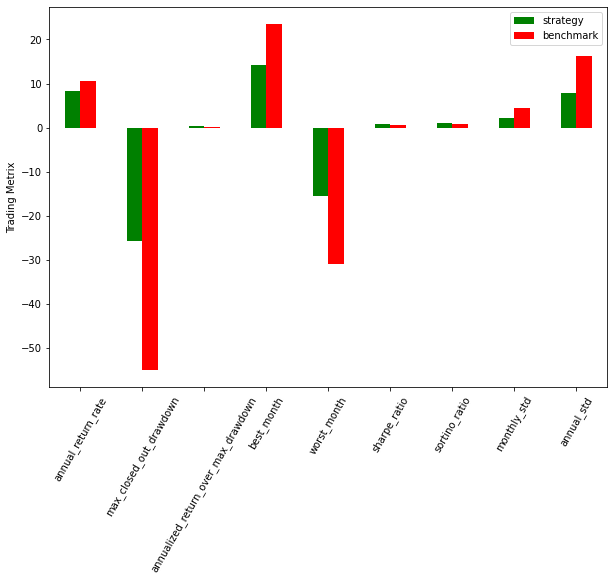

In [17]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df